In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
import colorcet as cc
import calendar
import statsmodels.api as sm
from scipy import stats

In [ ]:
datadir = Path().absolute().parent / "evaluation/working"
figdir = Path().absolute().parent / "evaluation/figures"
stationdir = Path().absolute().parent / "evaluation/weatherstationdata/SNAP"
filepattern_ERA5 = 'wind_{airport}_1980_2019_{resolution}.csv'
filepattern_station = "alaska_airports_hourly_winds_{ioac}.csv"

In [ ]:
stations = {
    "ANC_PANC": "PANC",
    "FAI_PAFA": "PAFA",
    "UTQ_PABR": "PABR",
    "BTH_PABE": "PABE"
}
startdate = '1980-01-01'
enddate = '2019-12-31'
fullnames = list(stations.keys())
resolutions = ['4km', '12km']
teststation = 'UTQ_PABR'

In [ ]:
def get_dataframe_ERA5(station, startdate=startdate, enddate=enddate):
    dfs = {}
    for res in resolutions:
        dfs[res] = pd.read_csv(
            datadir / filepattern_ERA5.format(airport=station, resolution=res))
        dfs[res]['Time'] = pd.to_datetime(dfs[res]['Time'])
        dfs[res].rename(columns={'wspd10': f"wspd10_{res}", 'wdir10': f"wdir10_{res}"}, inplace=True)
        # dfs[res].set_index('Time')
    dfs['4km']['wspd10_12km'] = dfs['12km']['wspd10_12km']
    dfs['4km']['wdir10_12km'] = dfs['12km']['wdir10_12km']
    return dfs['4km']

def get_dataframe_station(station, startdate=startdate, enddate=enddate):
    return pd.read_csv(
        stationdir / filepattern_station.format(ioac=stations[station]))

def get_dataframe(station, startdate=startdate, enddate=enddate):
    ERA5df = get_dataframe_ERA5(station)
    stationdf = get_dataframe_station(station)
    stationdf['ws'] = stationdf['ws'] / 2.237 

    ERA5df.set_index('Time', inplace=True)
    ERA5df.index = pd.to_datetime(ERA5df.index)
    stationdf.set_index('ts', inplace=True)
    stationdf.index = pd.to_datetime(stationdf.index)

    return pd.merge(ERA5df, stationdf,
            how='inner', left_index=True, right_index=True)

In [ ]:
def get_label(location, variable):
    if variable==location:
        return stations[location.replace(' ', '_')]
    elif variable=='precip_mm_ERA5_12km':
        return 'ERA5-12km'
    elif variable=='precip_mm_ERA5_4km':
        return 'ERA5-4km'
    

In [ ]:
def get_name(location):
    name = location.split(' ')[0].title()
    if name == 'Barrow':
        return 'Utqiaġvik'
    else:
        return name

In [ ]:
def get_stats(location, monthlyDF):
    output = []
    for variable in (location, 'precip_mm_ERA5_12km', 'precip_mm_ERA5_4km'):
        for mth in range(1, 13):
            X = monthlyDF.query(f'month == {mth}')['year']
            Y = monthlyDF.query(f'month == {mth}')[variable]
            slope, _, r_value, p_value, _ = stats.linregress(X, Y)
            mean = Y.mean()
            output.append({
                "location": location.split(' ')[0].title(),
                'variable': get_label(location, variable),
                'month': mth, 
                'mean_monthly_mm': mean, 
                'trend': slope, 
                'p_value': p_value, 
                'r_value':r_value})
    return output

In [ ]:
def get_monthly(hourlyDF, 
                startdate=startdate, enddate=enddate):
    hourlyDF = hourlyDF.loc[startdate:enddate]
    monthly_avg = hourlyDF[['wspd10_4km', 'wspd10_12km', 'ws']].groupby(
        pd.Grouper(freq='D')).max().groupby(
        pd.Grouper(freq='M')).mean()
    monthly_avg['year'] = monthly_avg.index.year
    monthly_avg['month'] = monthly_avg.index.month
    return monthly_avg

In [ ]:
compDF = get_dataframe(teststation)
monthly_DF = get_monthly(compDF)
monthly_DF

/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_2286/1654113850.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).mean()


,wspd10_4km,wspd10_12km,ws,year,month
1980-01-31,6.933387,8.132710,7.894790,1980,1
1980-02-29,7.154483,8.370172,7.180029,1980,2
1980-03-31,6.524290,7.905903,7.064905,1980,3
1980-04-30,8.586400,10.246067,8.396215,1980,4
1980-05-31,8.052581,9.522645,8.059181,1980,5
...,...,...,...,...,...
2019-08-31,6.931355,8.168806,8.540384,2019,8
2019-09-30,5.698800,6.883133,7.179258,2019,9
2019-10-31,6.922516,9.007419,9.701069,2019,10
2019-11-30,7.061567,9.005167,9.818209,2019,11


In [ ]:
get_stats(location, monthly_sum)

NameError: name 'get_stats' is not defined

In [ ]:
output = []
for mth in range(1, 13):
    X = monthly_sum.query(f'month == {mth}')['year']
    Y = monthly_sum.query(f'month == {mth}')[location]
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
    mean = Y.mean()
    output.append((mth, mean, slope, p_value, r_value, std_err))

NameError: name 'location' is not defined

In [ ]:
output

[]

In [ ]:
mth = 8
X = monthly_DF.query(f'month == {mth}')['year']
Y = monthly_DF.query(f'month == {mth}')['ws']
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

In [ ]:
slope, intercept, p_value

(-0.007701679118247671, 20.91747365274037, 0.36105246536752233)

In [ ]:
cmap = plt.cm.get_cmap('cet_glasbey')
cmap = plt.cm.get_cmap('Set1')

/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_2286/1137458020.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('cet_glasbey')
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_2286/1137458020.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1')


In [ ]:
monthly_DF.index.name = 'Time'
df_forplot = pd.melt(monthly_DF.reset_index(), id_vars=[monthly_DF.index.name, 'year', 'month'], 
        value_vars=['wspd10_4km', 'wspd10_12km', 'ws'], value_name='wind', var_name=teststation)

In [ ]:
palette = sns.color_palette(cc.b_glasbey_category10, n_colors=3)
palette = sns.color_palette("Set2", 3)
viridis_palette = sns.color_palette("viridis", 25)
viridis_palette = [viridis_palette[ii] for ii in [14, 8, -1]]
viridis_palette

[(0.123444, 0.636809, 0.528763),
 (0.185556, 0.41857, 0.556753),
 (0.906311, 0.894855, 0.098125)]

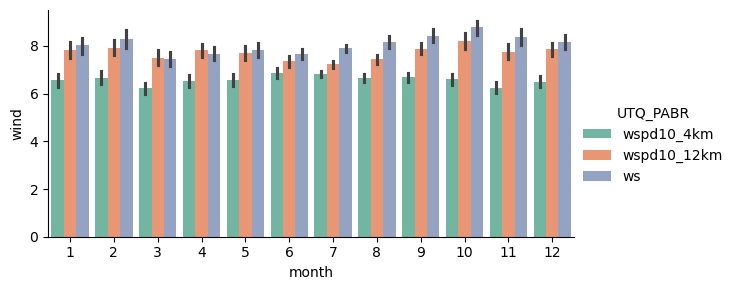

In [ ]:
g = sns.catplot(data=df_forplot, kind="bar", x="month", y="wind", 
            hue=teststation, palette='Set2', width=0.85, height=3, aspect=2)
# g._legend.remove()

In [ ]:
month_abbr = [calendar.month_abbr[ii] for ii in range(1, 13)]
month_initials = [item[0] for item in month_abbr]

/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_2286/177692953.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(month_abbr)


Text(0.5, 1.0, 'UTQ_PABR')

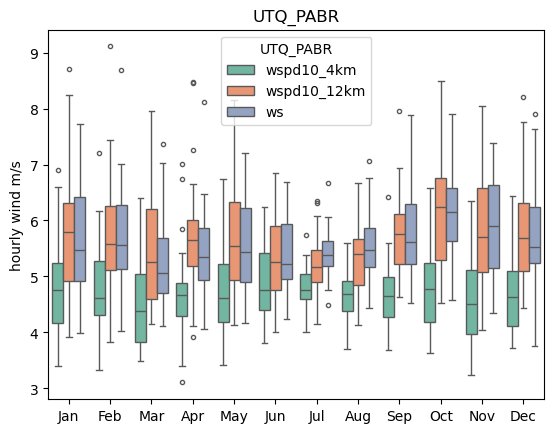

In [ ]:
g = sns.boxplot(data=df_forplot, x="month", y="wind", 
            hue=teststation, palette='Set2', legend=True, fliersize=3)
g.set_xticklabels(month_abbr)
g.set_xlabel('')
g.set_ylabel('hourly wind m/s')
g.set_title(teststation)

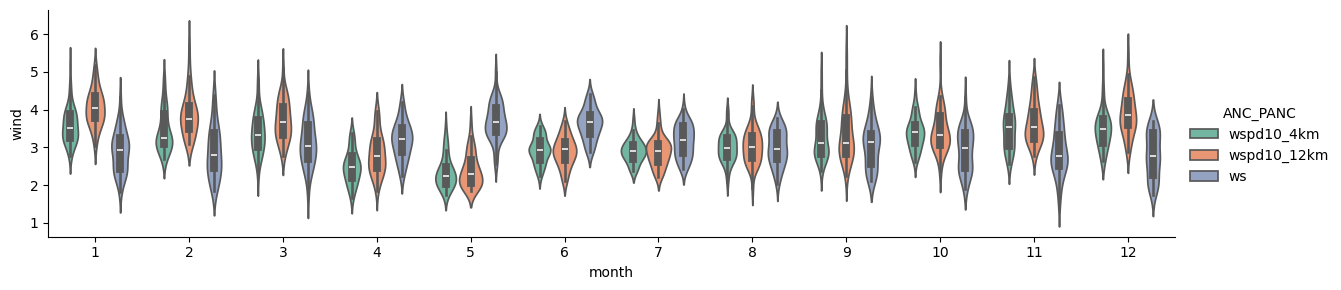

In [ ]:
g = sns.catplot(data=df_forplot, kind="violin", x="month", y="wind", 
            hue=teststation, palette=palette, height=3, aspect=4)


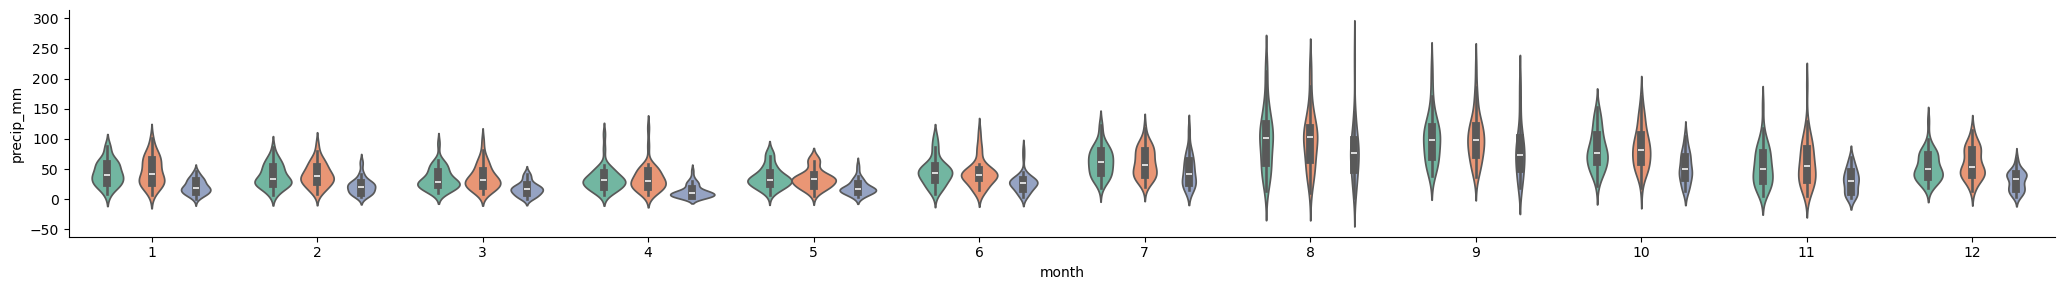

In [ ]:
g = sns.catplot(data=df_forplot, kind="violin", x="month", y="precip_mm", 
            hue="dataseries", palette=palette, height=3, aspect=7)
g._legend.remove()

<Axes: xlabel='Time'>

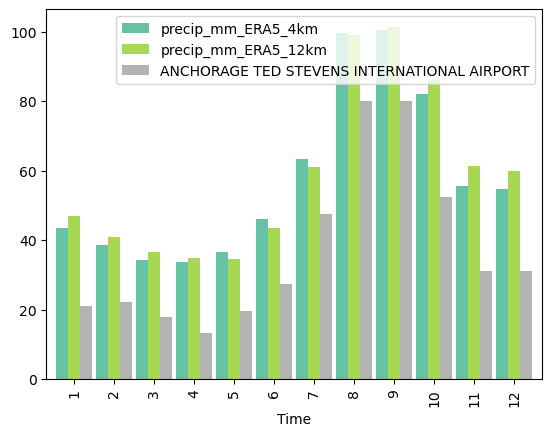

In [ ]:
monthly_sum.drop(columns=['month', 'year']).groupby(monthly_sum.index.month).mean().plot(
    kind='bar', width=0.9, cmap='Set2')

In [ ]:
monthly_sum

,precip_mm_ERA5_4km,precip_mm_ERA5_12km,ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT,year,month
Time,,,,,
1981-01-31,39.429,53.396,25.654,1981,1
1981-02-28,42.878,53.372,26.670,1981,2
1981-03-31,23.238,34.443,11.938,1981,3
1981-04-30,9.282,8.222,5.842,1981,4
1981-05-31,52.988,49.222,22.606,1981,5
...,...,...,...,...,...
2020-08-31,81.637,85.504,82.804,2020,8
2020-09-30,87.973,97.275,49.276,2020,9
2020-10-31,50.861,52.519,39.116,2020,10


In [ ]:
get_stats(location, monthly_sum)

[{'location': 'Anchorage',
  'variable': 'PANC',
  'month': 1,
  'mean_monthly_mm': 20.999450000000003,
  'trend': 0.19026172607879932,
  'p_value': 0.23343829038727423,
  'r_value': 0.19273939881777508},
 {'location': 'Anchorage',
  'variable': 'PANC',
  'month': 2,
  'mean_monthly_mm': 22.15515,
  'trend': 0.29519756097560973,
  'p_value': 0.10625497420052187,
  'r_value': 0.25922749922064714},
 {'location': 'Anchorage',
  'variable': 'PANC',
  'month': 3,
  'mean_monthly_mm': 17.7927,
  'trend': 0.2518078799249531,
  'p_value': 0.10308669108569161,
  'r_value': 0.2615217314309086},
 {'location': 'Anchorage',
  'variable': 'PANC',
  'month': 4,
  'mean_monthly_mm': 13.296899999999999,
  'trend': 0.10422101313320822,
  'p_value': 0.4680459413736727,
  'r_value': 0.11807921288915067},
 {'location': 'Anchorage',
  'variable': 'PANC',
  'month': 5,
  'mean_monthly_mm': 19.69135,
  'trend': -0.07279268292682929,
  'p_value': 0.6570555330031477,
  'r_value': -0.07240337967277742},
 {'locat

Make plots

/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/3667947206.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(month_abbr)
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/3667947206.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(month_abbr)
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning

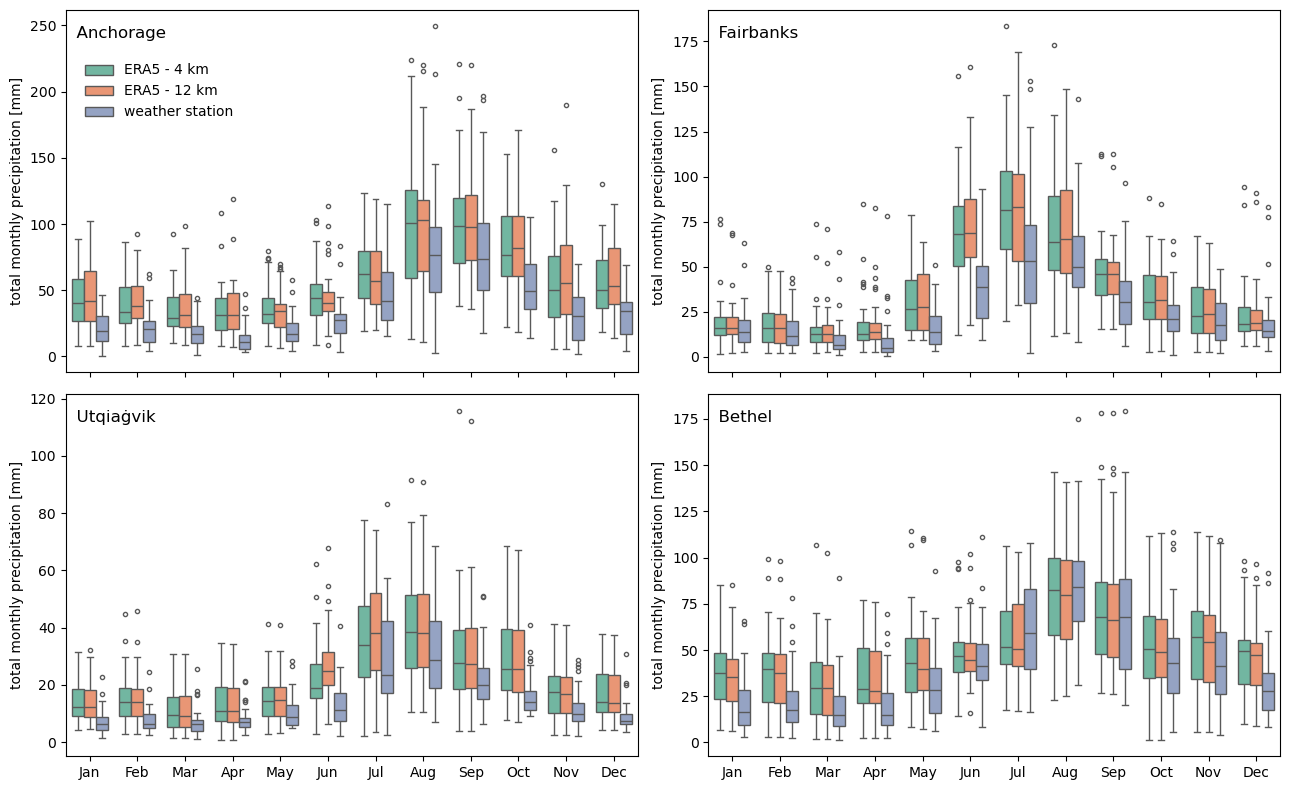

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8), sharex=True)

results = []
for ax, station in zip(axes.flatten(), stations):
    compDF = get_dataframe(station)
    location = station.replace('_', ' ')
    compDF.set_index('Time', inplace=True)
    monthly_sum = get_monthly(compDF, location, 
                              startdate=startdate, enddate=enddate)
    results.extend(get_stats(location, monthly_sum))
    df_forplot = pd.melt(monthly_sum.reset_index(), id_vars=[monthly_sum.index.name, 'year', 'month'], 
        value_vars=['precip_mm_ERA5_4km', 'precip_mm_ERA5_12km', location], value_name='precip_mm', var_name='dataseries')
    g = sns.boxplot(data=df_forplot, x="month", y="precip_mm", 
            hue="dataseries", palette="Set2", width=0.75, fliersize=3, ax=ax)
    ax.get_legend().remove()  
    g.set_xticklabels(month_abbr)
    g.set_xlabel('')
    g.set_ylabel('total monthly precipitation [mm]')
    ax.set_title('  ' + get_name(location), loc='left', y=0.9)
handles, _ = ax.get_legend_handles_labels()
labels = ['ERA5 - 4 km', 'ERA5 - 12 km', 'weather station']
fig.legend(handles, labels, loc='upper left', ncol=1, bbox_to_anchor=(0.06, 0.93), frameon=False)
plt.tight_layout()
    # g.fig.suptitle(location.split(' ')[0].title())

In [ ]:
fn = f"precip_stations_monthly_distribution_box_{startdate}-{enddate}.png"
fig.savefig(figdir / fn, bbox_inches='tight', dpi=300)

/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/3999468845.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(month_abbr)
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/3999468845.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(month_abbr)
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning

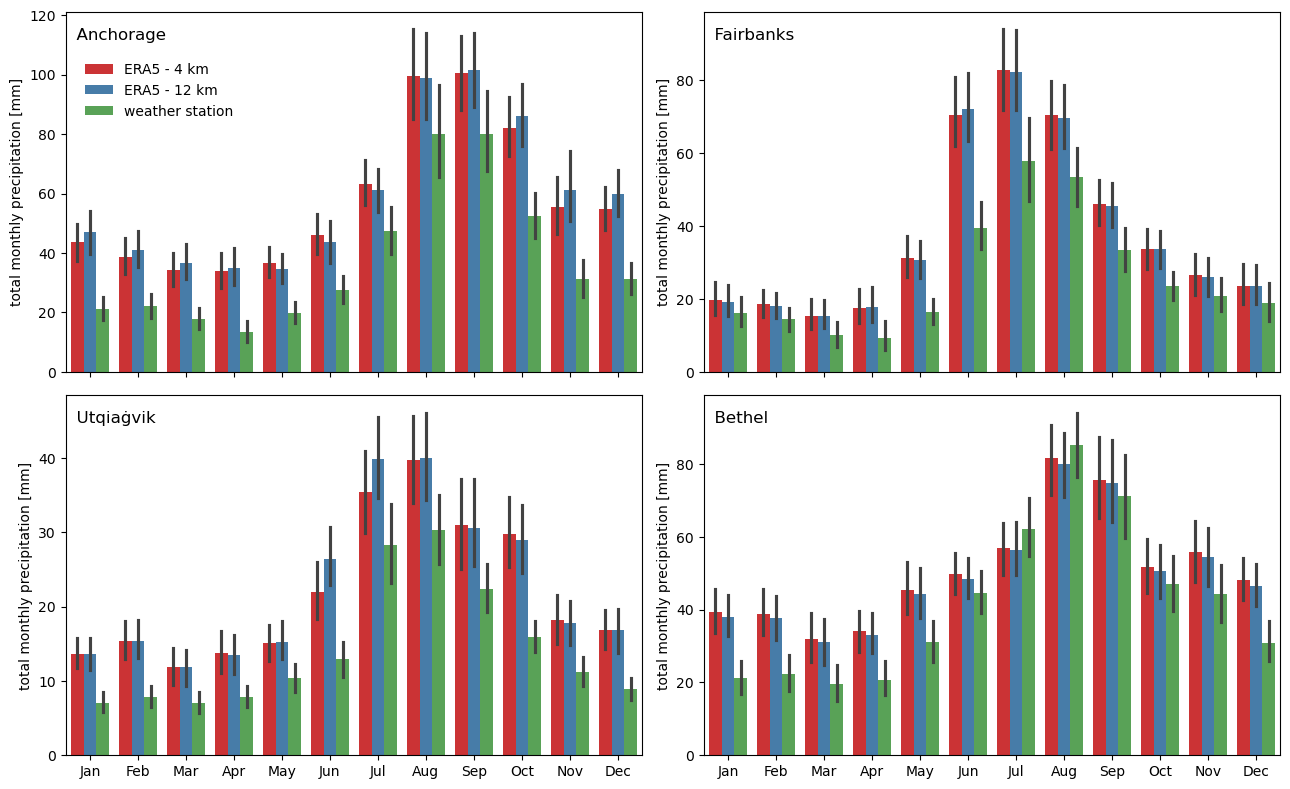

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8), sharex=True)

results = []
for ax, station in zip(axes.flatten(), stations):
    compDF = get_dataframe(station)
    location = station.replace('_', ' ')
    compDF.set_index('Time', inplace=True)
    monthly_sum = get_monthly(compDF, location, 
                              startdate=startdate, enddate=enddate)
    df_forplot = pd.melt(monthly_sum.reset_index(), id_vars=[monthly_sum.index.name, 'month'], 
        value_vars=['precip_mm_ERA5_4km', 'precip_mm_ERA5_12km', location], value_name='precip_mm', var_name='dataseries')
    g = sns.barplot(data=df_forplot, x="month", y="precip_mm", 
            hue="dataseries", palette='Set1', width=0.8, ax=ax)  
    ax.get_legend().remove()  
    g.set_xticklabels(month_abbr)
    g.set_xlabel('')
    g.set_ylabel('total monthly precipitation [mm]')
    ax.set_title('  ' + get_name(location), loc='left', y=0.9)
handles, _ = ax.get_legend_handles_labels()
labels = ['ERA5 - 4 km', 'ERA5 - 12 km', 'weather station']
fig.legend(handles, labels, loc='upper left', ncol=1, bbox_to_anchor=(0.06, 0.93), frameon=False)

plt.tight_layout()

In [ ]:
fn = f"precip_stations_monthly_distribution_bar_{startdate}-{enddate}.png"
fig.savefig(figdir / fn, bbox_inches='tight', dpi=300)

/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/155049449.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(month_abbr)
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/155049449.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(month_abbr)
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 

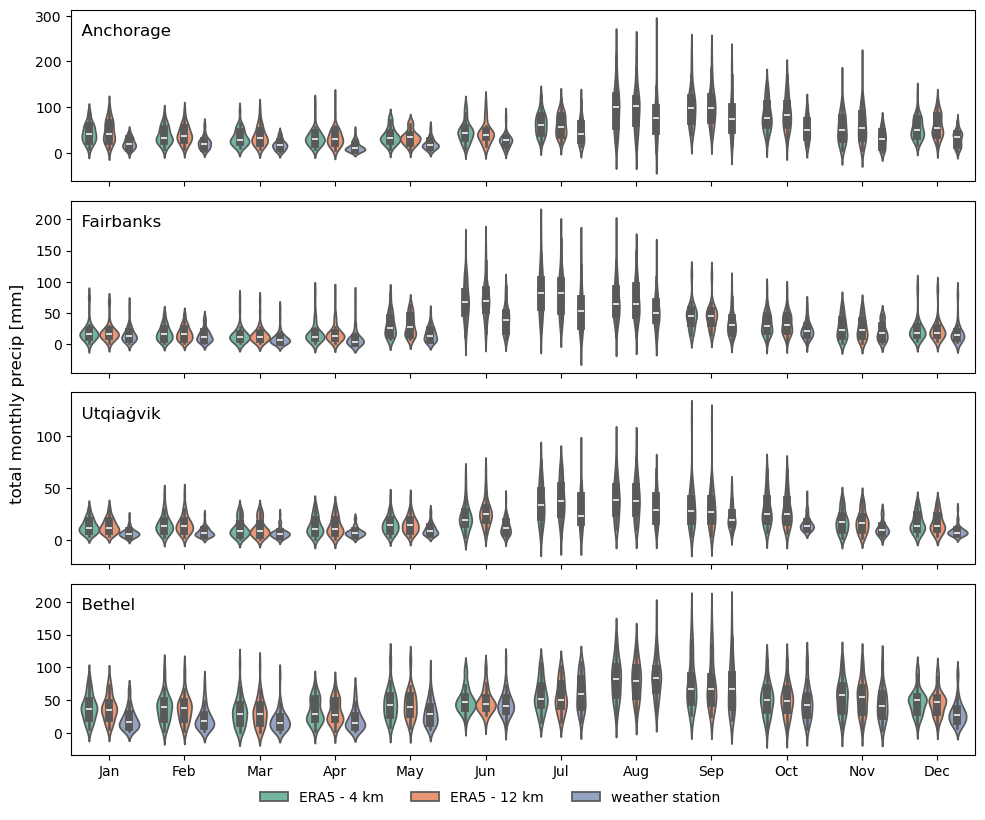

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8), sharex=True)

for ax, station in zip(axes.flatten(), stations):
    compDF = get_dataframe(station)
    location = station.replace('_', ' ')
    compDF.set_index('Time', inplace=True)
    monthly_sum = get_monthly(compDF, location, 
                              startdate=startdate, enddate=enddate)
    df_forplot = pd.melt(monthly_sum.reset_index(), id_vars=[monthly_sum.index.name, 'month'], 
        value_vars=['precip_mm_ERA5_4km', 'precip_mm_ERA5_12km', location], value_name='precip_mm', var_name='dataseries')
    g = sns.violinplot(data=df_forplot, x="month", y="precip_mm", 
            hue="dataseries", palette=palette, ax=ax)  
    ax.get_legend().remove()  
    g.set_xticklabels(month_abbr)
    g.set_xlabel('')
    g.set_ylabel('')
    ax.set_title('  ' + get_name(location), loc='left', y=0.8)
handles, _ = ax.get_legend_handles_labels()
labels = ['ERA5 - 4 km', 'ERA5 - 12 km', 'weather station']
fig.supylabel('total monthly precip [mm]')
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02), frameon=False)

plt.tight_layout()

In [ ]:
fn = f"precip_stations_monthly_distribution_violin_{startdate}-{enddate}.png"
fig.savefig(figdir / fn, bbox_inches='tight', dpi=300)

In [ ]:
results = []
for station in stations:
    compDF = get_dataframe(station)
    location = station.replace('_', ' ')
    compDF.set_index('Time', inplace=True)
    monthly_sum = get_monthly(compDF, location)

    results.extend(get_stats(location, monthly_sum))

/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/911239567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(freq='M')).sum()


In [ ]:
resultsDF = pd.DataFrame.from_records(results)
resultsDF

,location,variable,month,mean_monthly_mm,trend,p_value,r_value
0,Anchorage,PANC,1,20.999450,0.190262,0.233438,0.192739
1,Anchorage,PANC,2,22.155150,0.295198,0.106255,0.259227
2,Anchorage,PANC,3,17.792700,0.251808,0.103087,0.261522
3,Anchorage,PANC,4,13.296900,0.104221,0.468046,0.118079
4,Anchorage,PANC,5,19.691350,-0.072793,0.657056,-0.072403
...,...,...,...,...,...,...,...
139,Bethel,ERA5-4km,8,81.763975,-0.249162,0.553325,-0.096570
140,Bethel,ERA5-4km,9,75.575650,-0.389067,0.447444,-0.123573
141,Bethel,ERA5-4km,10,51.754975,0.434380,0.197895,0.207943
142,Bethel,ERA5-4km,11,55.950900,-0.089447,0.806944,-0.039888


In [ ]:
def add_significance_suffix(p_value):
    if p_value < 0.05:
        return ' (**)'
    elif p_value < 0.1:
        return ' (*)'
    else: return ''

In [ ]:
tableDF = resultsDF.query('variable != "ERA5-12km"')
tableDF['ID'] = tableDF.location + ': ' + tableDF['variable']
tableDF['strtrend'] = tableDF['trend'].round(2).astype(str) 
tableDF['sigtrend'] = tableDF['strtrend'] + tableDF['p_value'].apply(add_significance_suffix)


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/611527881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tableDF['ID'] = tableDF.location + ': ' + tableDF['variable']
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/611527881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tableDF['strtrend'] = tableDF['trend'].round(2).astype(str)
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_15342/611527881.py:4: SettingWithCopyWarning: 
A value is trying to be set on

In [ ]:
sigtable = tableDF.pivot(index='ID', columns='month', values='sigtrend')
sigtable.columns = [calendar.month_abbr[ii] for ii in sigtable.columns]
sigtable

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ID,,,,,,,,,,,,
Anchorage: ERA5-4km,-0.07,0.26,-0.02,0.19,-0.27,-0.02,0.31,-0.43,0.25,-0.25,0.29,-0.09
Anchorage: PANC,0.19,0.3,0.25,0.1,-0.07,0.11,0.08,-0.55,0.26,-0.45,0.12,0.23
Barrow: ERA5-4km,-0.03,0.08,0.11,0.05,0.22 (*),0.2,0.3,-0.09,-0.05,0.35 (*),0.49 (**),0.09
Barrow: PABR,0.09,0.18 (**),0.2 (**),0.1 (*),0.23 (**),0.24 (**),0.16,0.09,0.09,0.26 (**),0.44 (**),0.2 (**)
Bethel: ERA5-4km,-0.1,0.59 (**),-0.21,0.32,0.14,0.09,0.29,-0.25,-0.39,0.43,-0.09,-0.53 (**)
Bethel: PABE,0.07,0.44 (*),-0.05,0.2,0.3,0.2,0.63 (*),0.22,0.65,0.59 (*),0.37,-0.21
Fairbanks: ERA5-4km,-0.06,0.11,0.21,0.14,-0.23,0.22,-0.6,0.87 (**),0.3,-0.08,0.18,-0.27
Fairbanks: PAFA,-0.0,0.19,0.21,0.13,-0.07,0.29,0.54,0.67 (*),0.48 (*),-0.2,0.19,-0.22
